# 무신사 스냅 이미지를 이용한 패션 스타일 분류

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import tensorflow as tf
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential

import tensorflow as tf
tf.random.set_seed(2)

import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/스타일", output="output", seed=1337, ratio=(.8, .2))

Copying files: 14822 files [00:26, 555.71 files/s]


In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
# 스타일 종류
class_list = ['걸리시', '댄디', '로맨틱', '스트릿', '스포츠', '시크', '캐주얼', '포멀']

data_dir = "/content/drive/MyDrive/스타일"

tf.random.set_seed(2)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="training",
  labels='inferred',
  label_mode="categorical",
  class_names=class_list,
  shuffle=True,
  validation_split=0.2,
  seed=2,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="validation",
  labels='inferred',
  label_mode="categorical",
  class_names=class_list,
  shuffle=True,
  validation_split=0.2,
  seed=2,
  batch_size=batch_size)

Found 14822 files belonging to 8 classes.
Using 11858 files for training.
Found 14822 files belonging to 8 classes.
Using 2964 files for validation.


In [ ]:
# 클래스 이름(스타일 종류)
class_names = train_ds.class_names
print(class_names)

['걸리시', '댄디', '로맨틱', '스트릿', '스포츠', '시크', '캐주얼', '포멀']


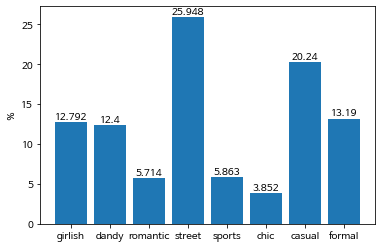

In [ ]:
# 스타일별 이미지 개수
style_count = []
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    count = 0
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # PetImages/Cat/63.jpg
        count += 1
    style_count.append(round((count/14822)*100, 3))
  
# 시각화
x = np.arange(8)
plt.bar(x, style_count)
plt.xticks(x,["girlish", 'dandy', 'romantic', 'street', 'sports', 'chic', 'casual', 'formal'])
plt.ylabel('%')
for i, v in enumerate(x):
    plt.text(v, style_count[i], style_count[i], fontsize = 10, color='black',
             horizontalalignment='center', verticalalignment='bottom') 
plt.show()

In [ ]:
import os

num_skipped = 0
for folder_name in class_names:
    folder_path = os.path.join("/content/drive/MyDrive/스타일", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # PetImages/Cat/63.jpg
        try:
            fobj = open(fpath, "rb")
            # fobj.peek(10)은 10바이트를 가져오는데, 여기서는 보통
            # 헤더를 읽기 위해 전체를 가져온다고 생각해도 무방합니다.
            is_JPG = tf.compat.as_bytes("jpeg") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_JPG:
            num_skipped += 1
            # Delete corrupted image
            #os.remove(fpath)
            #print(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


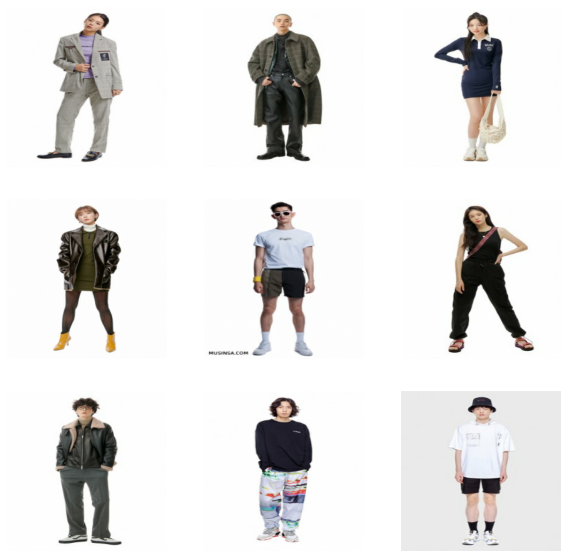

In [ ]:
# 이미지 예시
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.axis("off")

## 데이터 증강


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

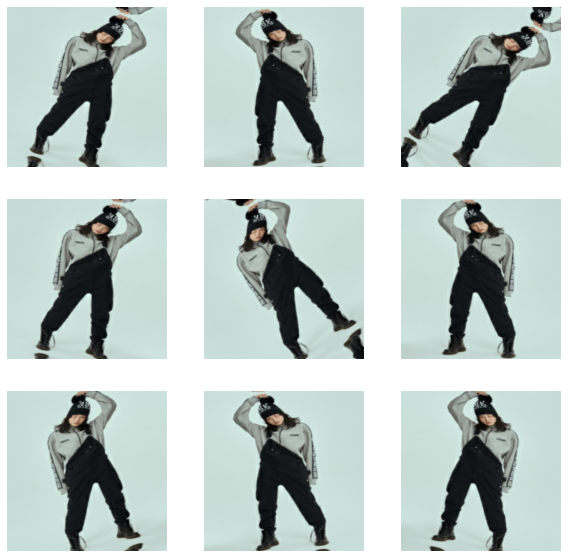

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

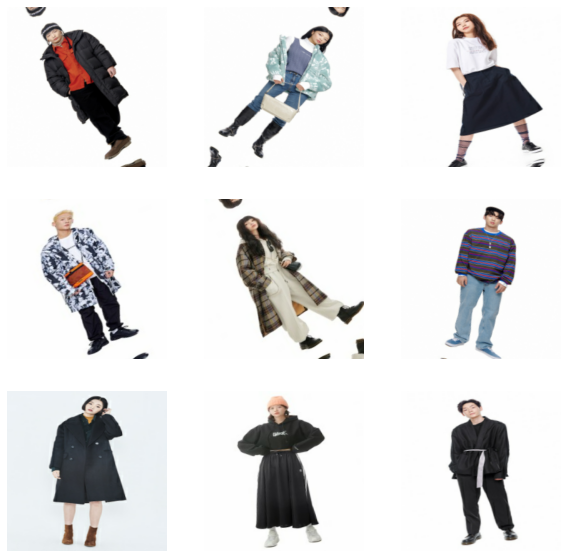

In [ ]:
import matplotlib.pyplot as plt

# figure 크기를 조절합니다.
plt.figure(figsize=(10, 10))

# 배치 하나를 가져옵니다.
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.axis("off")

## 모델링

In [ ]:
# 기본적인 CNN모델
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(augmented_train_ds,
          batch_size=128,
          validation_data=val_ds,
          epochs=10)

396/396 [==============================] - 928s 2s/step - loss: 30.1579 - accuracy: 0.2475 - val_loss: 1.8836 - val_accuracy: 0.2554
Epoch 2/10
396/396 [==============================] - 105s 264ms/step - loss: 1.8981 - accuracy: 0.2538 - val_loss: 1.8660 - val_accuracy: 0.2551
Epoch 3/10
396/396 [==============================] - 105s 264ms/step - loss: 1.8921 - accuracy: 0.2498 - val_loss: 1.8708 - val_accuracy: 0.2500
Epoch 4/10
396/396 [==============================] - 105s 264ms/step - loss: 1.8872 - accuracy: 0.2560 - val_loss: 1.8632 - val_accuracy: 0.2604
Epoch 5/10
396/396 [==============================] - 105s 264ms/step - loss: 1.8852 - accuracy: 0.2545 - val_loss: 1.8692 - val_accuracy: 0.2614
Epoch 6/10
396/396 [==============================] - 105s 263ms/step - loss: 1.8829 - accuracy: 0.2573 - val_loss: 1.8739 - val_accuracy: 0.2497
Epoch 7/10
396/396 [==============================] - 105s 265ms/step - loss: 1.8942 - accuracy: 0.2519 - val_loss: 1.8706 - val_accuracy

In [ ]:
# VGG16 모델
pretrained_model = VGG16(weights='imagenet', include_top=False)
model2 = Sequential()
model2.add(pretrained_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128,activation='relu'))
model2.add(Dense(8,activation='softmax'))


model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_ds,
          batch_size=128,
          validation_data=val_ds,
          epochs=10)

## ResNet 모델


In [ ]:
# ResNet 모델
resnet = ResNet50(weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x) # 출력층
ResNet_model = Model(resnet.input, predictions)

ResNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ResNet_model.fit(augmented_train_ds, batch_size=64, validation_data=val_ds, epochs=20)

Epoch 1/20
371/371 [==============================] - 150s 388ms/step - loss: 1.6035 - accuracy: 0.4119 - val_loss: 1.3711 - val_accuracy: 0.4868
Epoch 2/20
371/371 [==============================] - 141s 378ms/step - loss: 1.3503 - accuracy: 0.4763 - val_loss: 1.3464 - val_accuracy: 0.4993
Epoch 3/20
371/371 [==============================] - 141s 379ms/step - loss: 1.2955 - accuracy: 0.5011 - val_loss: 1.3437 - val_accuracy: 0.4767
Epoch 4/20
371/371 [==============================] - 140s 378ms/step - loss: 1.2585 - accuracy: 0.5110 - val_loss: 1.3489 - val_accuracy: 0.5027
Epoch 5/20
371/371 [==============================] - 140s 376ms/step - loss: 1.2206 - accuracy: 0.5186 - val_loss: 1.2620 - val_accuracy: 0.5135
Epoch 6/20
371/371 [==============================] - 140s 376ms/step - loss: 1.1885 - accuracy: 0.5362 - val_loss: 1.3031 - val_accuracy: 0.5007
Epoch 7/20
371/371 [==============================] - 140s 377ms/step - loss: 1.1760 - accuracy: 0.5446 - val_loss: 1.2278 -

In [ ]:
ResNet_model.evaluate(val_ds)

# 15822(캐주얼 4000) = 0.5009
# 14822(캐주얼 3000) = 0.5162   1시간 20분  512   128
# 14822(캐주얼 3000) = 0.5233   46분        1024   64

93/93 [==============================] - 13s 139ms/step - loss: 1.2577 - accuracy: 0.5233


[1.257735013961792, 0.5232793688774109]

In [ ]:
ResNet_model.summary()

In [ ]:
from keras.models import load_model

ResNet_model.save('ResNet_model.h5')


In [ ]:
from keras.models import load_model
model = load_model('/content/ResNet_model.h5')

## pytorch 예제


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# 훈련 / 데이터 세트
train_path = '/content/output/train'
test_path = '/content/output/val'

In [ ]:
# tensor 형식으로 변경
resize_trans = transforms.Compose([
                                   transforms.Resize((256,256)),
                                   transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [ ]:
resize_train[0][0].shape 

torch.Size([3, 256, 256])

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor()
    ])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

torch.Size([1, 3, 124, 124])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

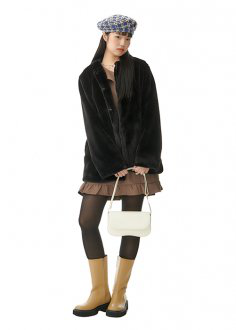

In [ ]:
none_trans[359][0]

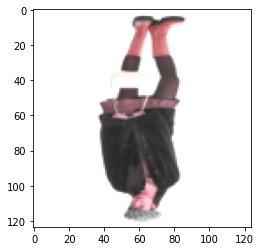

In [ ]:
imshow(trainset[359][0])

In [ ]:
from torch.utils.data import Dataset, DataLoader                                # 데이터 커스터마이징
from PIL import Image                                                           # PIL = Python Image Library
import cv2                                                                      # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

data_path = '/content/output'
class inhovation_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 라벨 ['걸리시', '댄디', '로맨틱', '스트릿', '스포츠', '시크', '캐주얼', '포멀']
    label=[]                                
    for i, name in enumerate(class_names):
      if os.path.basename(data_path).startswith(name) == True:                  
          label = i
      
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

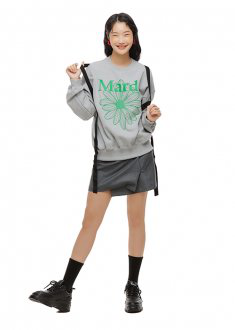

In [ ]:
Image.open(inhovation_Dataset(data_path, "train", transform = None).all_data[0])

In [ ]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 8, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [ ]:
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [ ]:
lr = 0.0008
epochs = 30
optimizer = 'Adam'

In [ ]:
# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [ ]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              lr_sche.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  #with test_summary_writer.as_default():
                  #    summary.scalar('loss', test_loss , step = self.globaliter)
                  #    summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
      print('Finished Training')

Finished Training


In [ ]:
ready_to_train=train_test(config)

186


In [ ]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 10
log_interval = 175

ready_to_train.train(epochs, log_interval)